In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.utils import compute_class_weight

from preprocessing import TrainingPreProcessor

RANDOM_STATE = 0

train_set = pd.read_csv("input/train.csv")

train_set.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,713071383,Existing Customer,54,F,1,Unknown,Single,Unknown,Blue,36,...,3,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464
1,714246333,Attrited Customer,58,F,4,High School,Married,Unknown,Blue,48,...,4,3,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334
2,718206783,Existing Customer,45,F,4,Unknown,Single,Less than $40K,Gold,36,...,1,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103
3,721096983,Existing Customer,34,F,2,Graduate,Single,Less than $40K,Blue,36,...,3,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694
4,720028683,Existing Customer,49,F,2,High School,Married,$40K - $60K,Blue,39,...,3,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708


In [3]:
training_preprocessor = TrainingPreProcessor()
training_preprocessor.fit(train_set, ignore_columns=['CLIENTNUM'])

In [4]:
X, y = training_preprocessor.transform(train_set)
X.shape, y.shape

((8101, 37), (8101,))

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

In [6]:
classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight = {key: value for key, value in zip(classes, weights)}
labels = training_preprocessor.label_encoder.inverse_transform(classes)
class_label = {key: value for key, value in zip(classes, labels)}
print(class_weight, class_label, sep='\n')

{0: 3.1157692307692306, 1: 0.5955741802676077}
{0: 'Attrited Customer', 1: 'Existing Customer'}


In [8]:
def get_cm_sklearn(model, data_eval, labels):
  X_eval, y_eval = data_eval
  y_pred = model.predict(X_eval)
  _, axs = plt.subplots(1, 4, figsize=(22, 5))
  axs = axs.flatten()

  titles = [
      '\nnormalizada pelos valores reais',
      '\nnormalizada pelos valores preditos',
      '\nnormalizada pelos pela população',
      ''
  ]
  normalizes = ['true', 'pred', 'all', None]


  bal_acc = None
  acc = None
  for ax, title, normalize in zip(axs, titles, normalizes):
    cm = confusion_matrix(
        y_eval,
        y_pred,
        normalize=normalize
    )
    sns.set(font_scale=0.9)
    sns.heatmap(cm,
                cmap="YlGnBu",
                linewidths=.5,
                fmt='.1%' if normalize else '.0f',
                annot=True,
                cbar=False,
                ax=ax,
                xticklabels=labels,
                yticklabels=labels
    )
    ax.set(xlabel="Predição", ylabel="Valor Real", title=f'Matriz de confusão{title}')
    if normalize is None:
      sensitivity = cm[1][1] / (cm[1][1] + cm[1][0]) # TP / (TP + FN)
      specificity = cm[0][0] / (cm[0][0] + cm[0][1])# TN / (TN + FP)
      bal_acc = (sensitivity + specificity) / 2# (Sensitivity + Specificity) / 2
      acc = (cm[1][1] + cm[0][0]) / (
          cm[1][1] + cm[1][0] +
          cm[0][0] + cm[0][1]
      )

  plt.show()

### Definição e treinamento do modelo regressão logística

In [9]:
logistic_regression_model = LogisticRegression(random_state=RANDOM_STATE, class_weight=class_weight,  max_iter=1000)
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 3.1157692307692306, 1: 0.5955741802676077},
                   max_iter=1000, random_state=0)

### Avaliação do modelo regressão logística

Accuracy: 0.8519432449105491
Balanced Accuracy: 0.8365736888334142
F1: 0.9073359073359073
RoC AuC: 0.8365736888334142


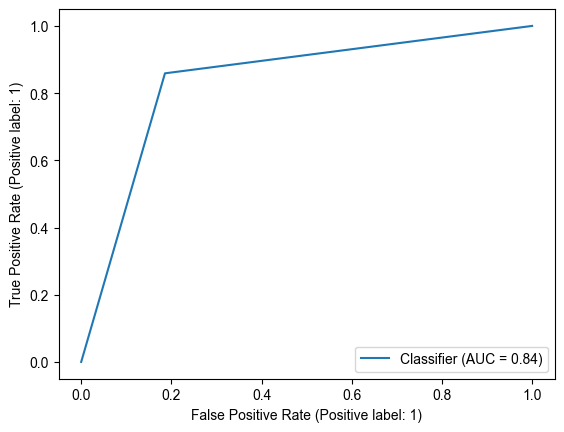

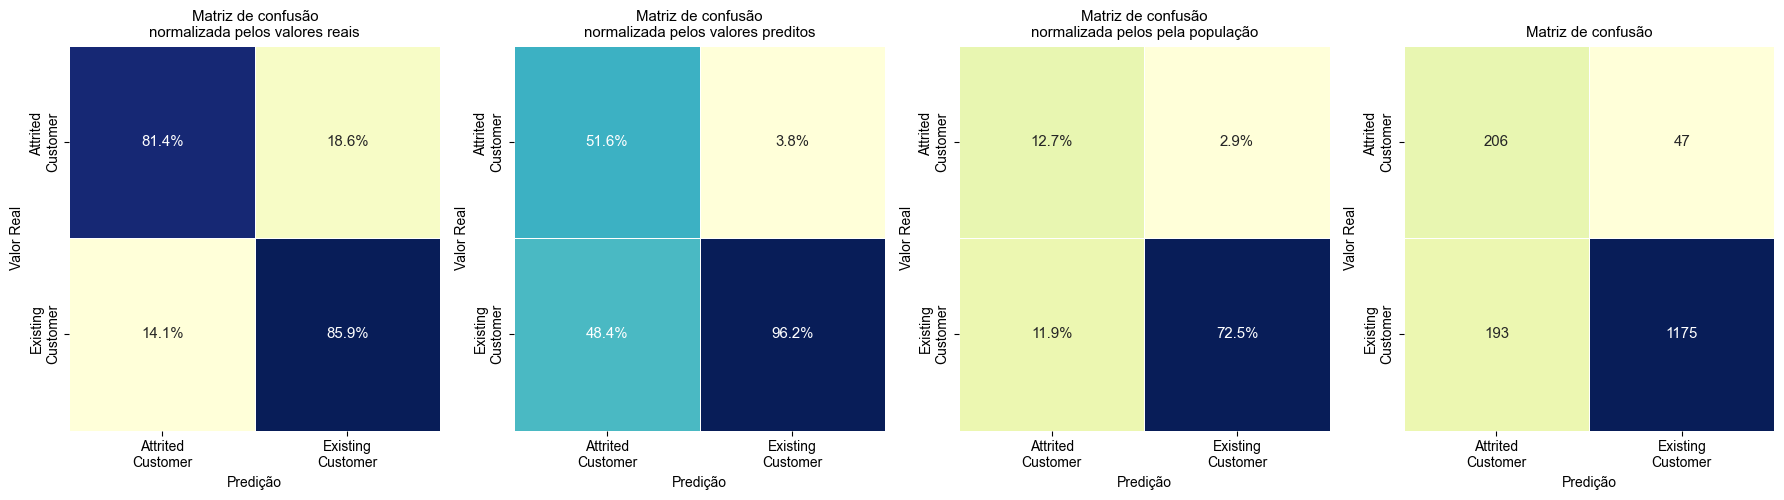

In [12]:
# Avaliação do modelo de Regressão Logística
y_pred_val_logistic = logistic_regression_model.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred_val_logistic)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val_logistic)}")
print(f"F1: {f1_score(y_val, y_pred_val_logistic)}")
print(f"RoC AuC: {roc_auc_score(y_val, y_pred_val_logistic)}")
RocCurveDisplay.from_predictions(y_val, y_pred_val_logistic)

get_cm_sklearn(
    logistic_regression_model,
    data_eval=(X_val, y_val),
    labels=["\n".join(label.split()) for label in labels],
)

### Definição e treinamento do modelo SVC

In [9]:
svc_model = SVC(random_state=RANDOM_STATE, class_weight=class_weight)
svc_model.fit(X_train, y_train)

SVC(class_weight={0: 3.1157692307692306, 1: 0.5955741802676077}, random_state=0)

### Avaliação do modelo SVC

Accuracy: 0.9136335595311537
Balanced Accuracy: 0.9037283591059335
F1: 0.947209653092006
RoC AuC: 0.9037283591059334


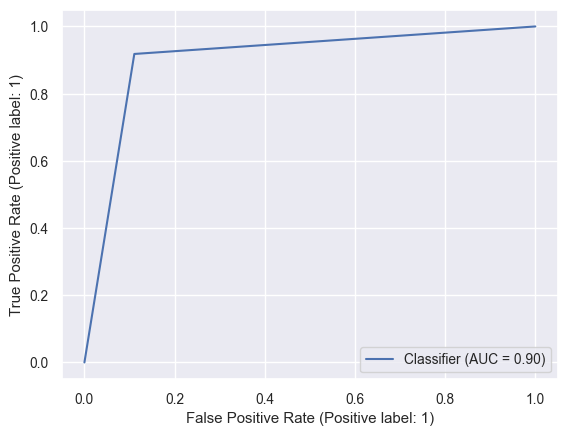

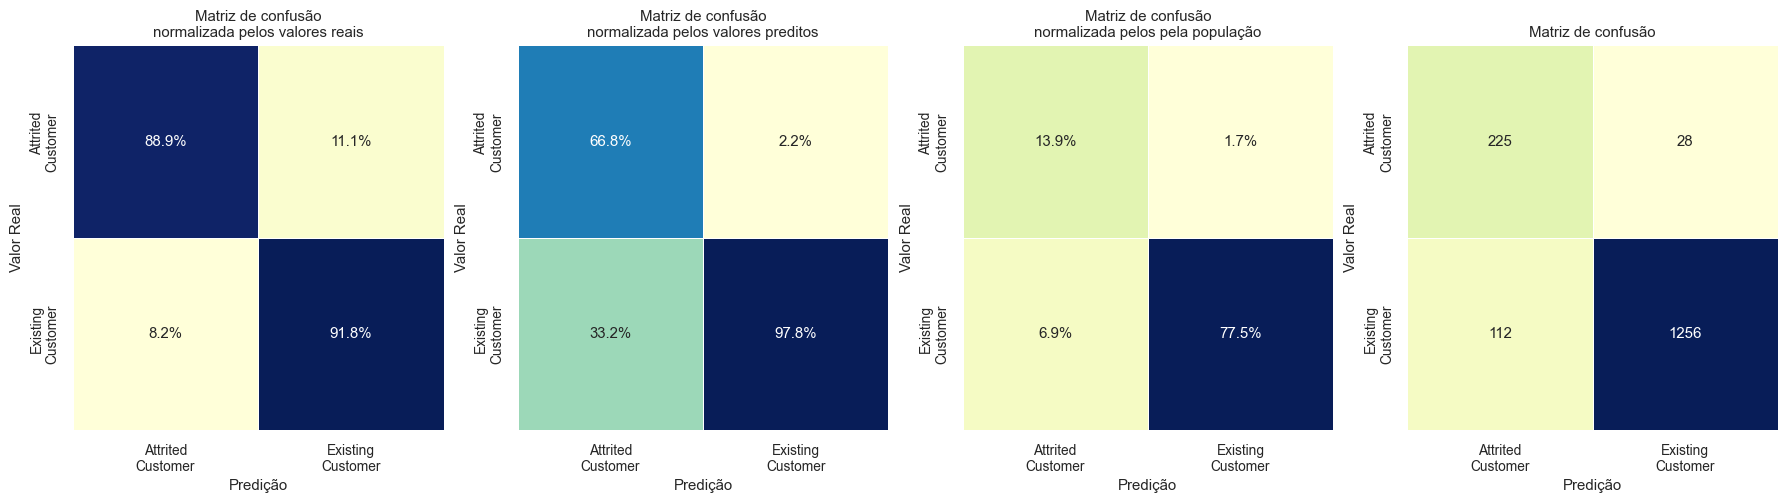

In [10]:
y_pred_val_svc = svc_model.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred_val_svc)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val_svc)}")
print(f"F1: {f1_score(y_val, y_pred_val_svc)}")
print(f"RoC AuC: {roc_auc_score(y_val, y_pred_val_svc)}")
RocCurveDisplay.from_predictions(y_val, y_pred_val_svc)

get_cm_sklearn(
    svc_model,
    data_eval=(X_val, y_val),
    labels=["\n".join(label.split()) for label in labels],
)

### Definição e treinamento do modelo floresta aleatória

In [11]:
rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight=class_weight
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 3.1157692307692306,
                                     1: 0.5955741802676077},
                       random_state=0)

### Avaliação do modelo floresta aleatória

Accuracy: 0.9450956199876619
Balanced Accuracy: 0.8531048470979821
F1: 0.968088920760129
RoC AuC: 0.8531048470979823


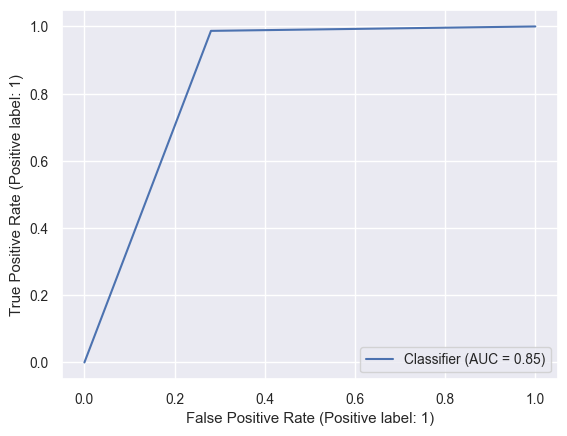

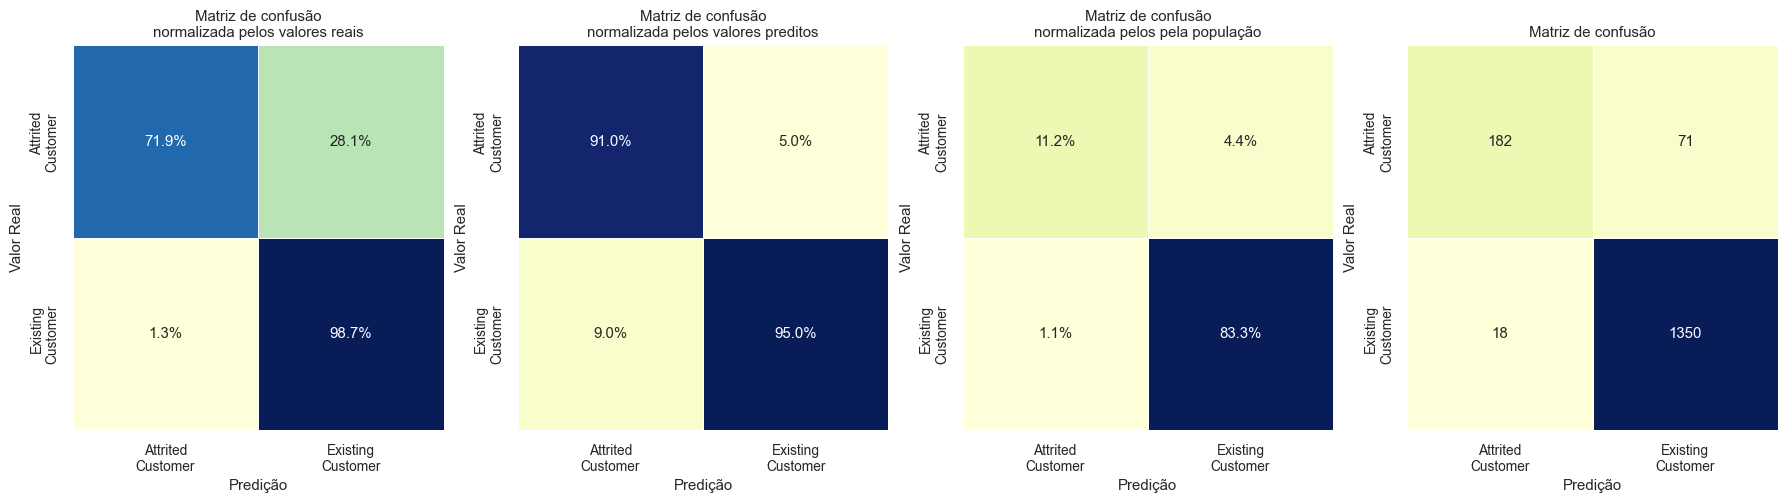

In [12]:
y_pred_val = rf_model.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val)}")
print(f"F1: {f1_score(y_val, y_pred_val)}")
print(f"RoC AuC: {roc_auc_score(y_val, y_pred_val)}")
RocCurveDisplay.from_predictions(y_val, y_pred_val)

get_cm_sklearn(
    rf_model,
    data_eval=(X_val, y_val),
    labels=["\n".join(label.split()) for label in labels],
)